# Визуализация промежуточных активаций

In [127]:
import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.cm as cm

## Загрузка модели

In [2]:
model = keras.models.load_model("models/convnet_from_scratch_with_augmentation.x")
model.summary()

2024-04-02 11:34:53.701700: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-04-02 11:34:53.701718: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-04-02 11:34:53.701723: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-04-02 11:34:53.701753: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-02 11:34:53.701769: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [3]:
img_path = keras.utils.get_file(
    fname="cat.jpg", origin="https://img-datasets.s3.amazonaws.com/cat.jpg"
)


def get_img_array(img_path: str, target_size: tuple) -> np.ndarray:
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


img_tensor = get_img_array(img_path=img_path, target_size=(180, 180))

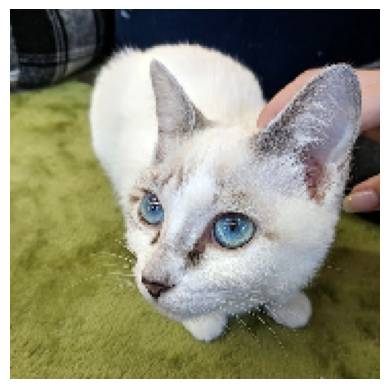

In [6]:
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [13]:
layer_outputs = []
layer_names = []

for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [14]:
activations = activation_model.predict(img_tensor)

2024-04-02 12:02:09.667710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 728ms/step


In [15]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


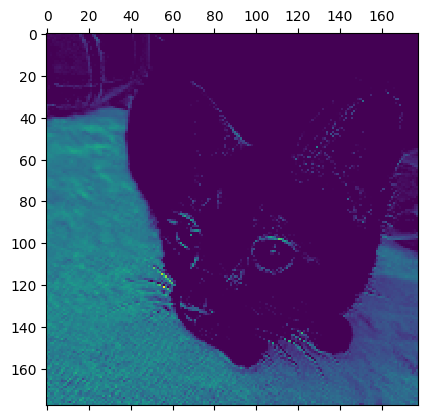

In [18]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

## Визуализация каждого канала для всех промежуточных активаций

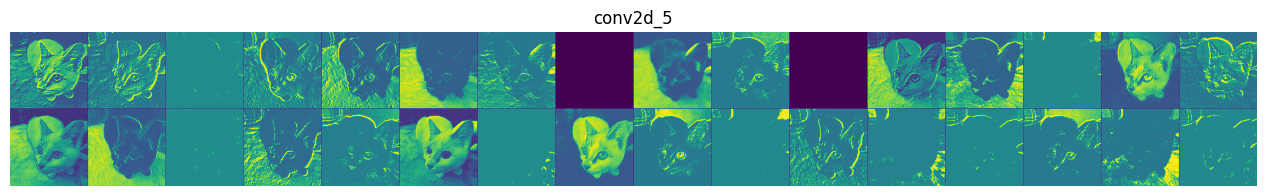

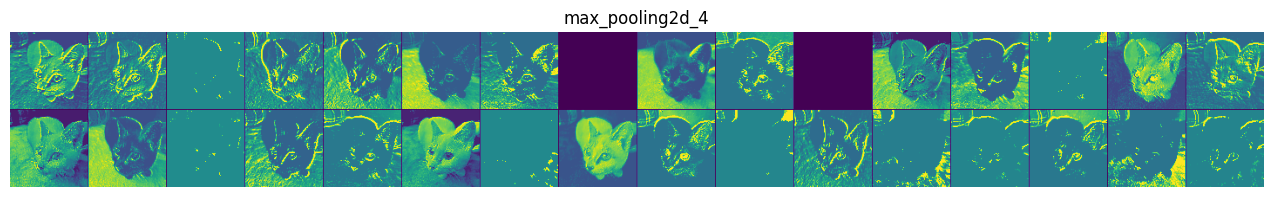

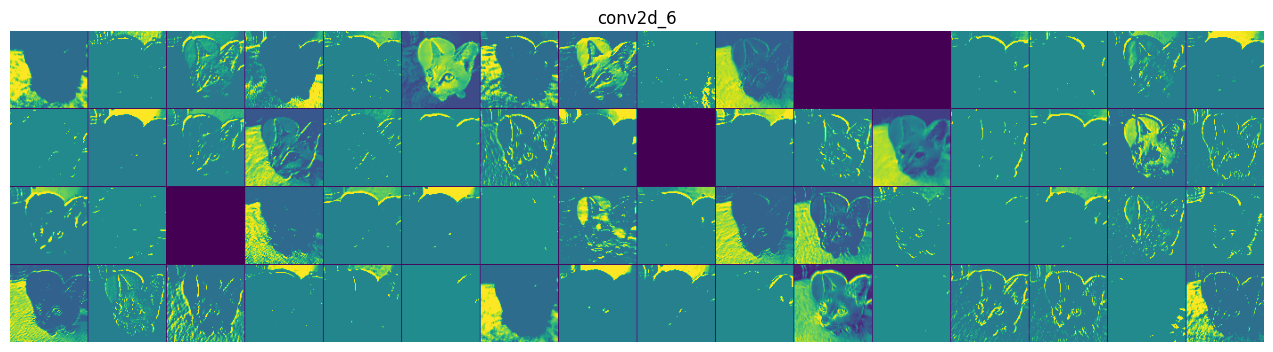

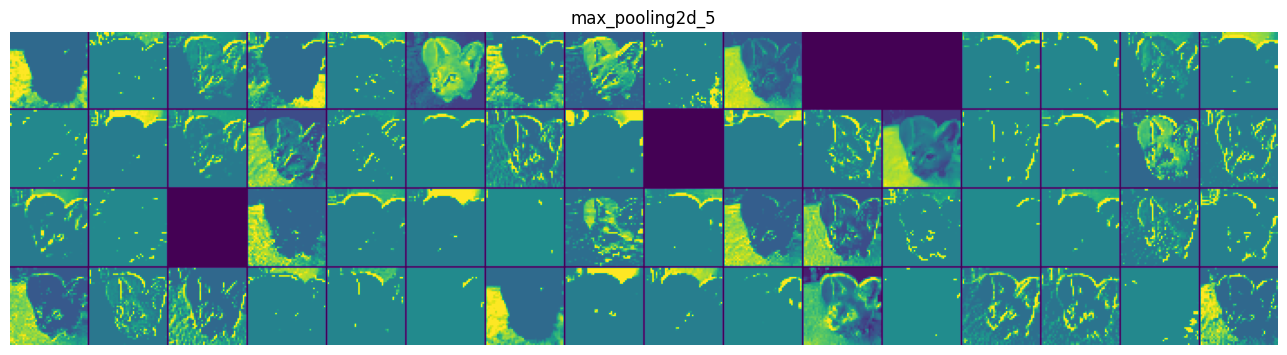

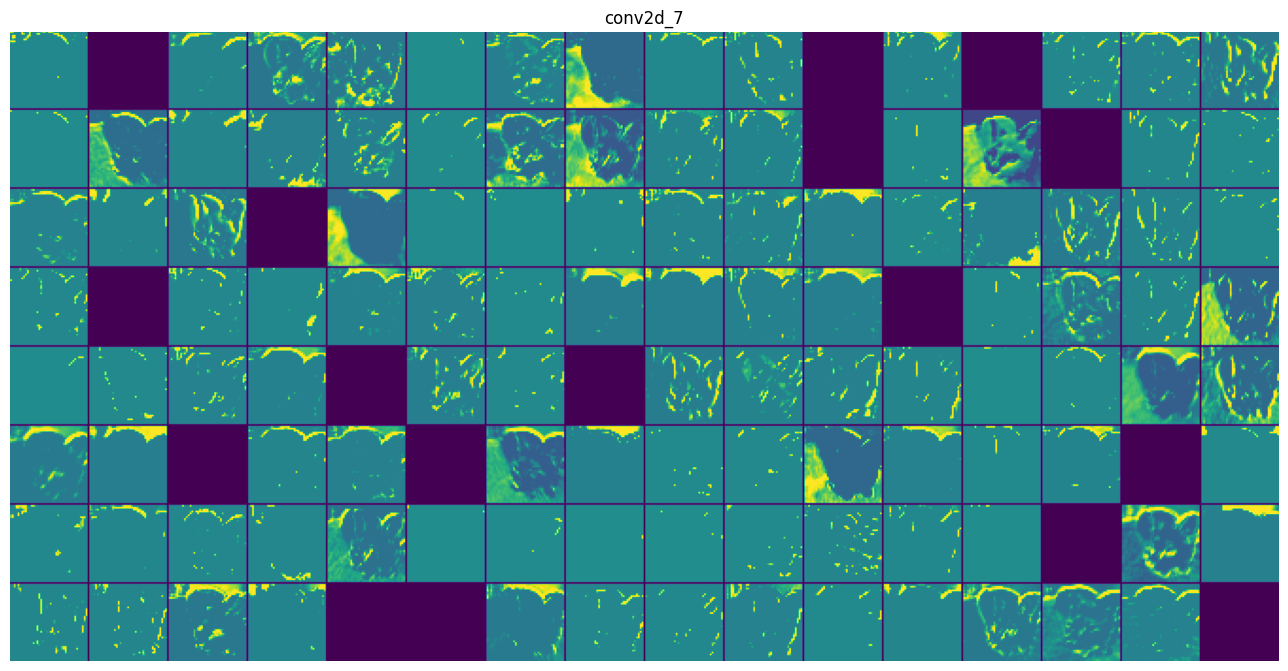

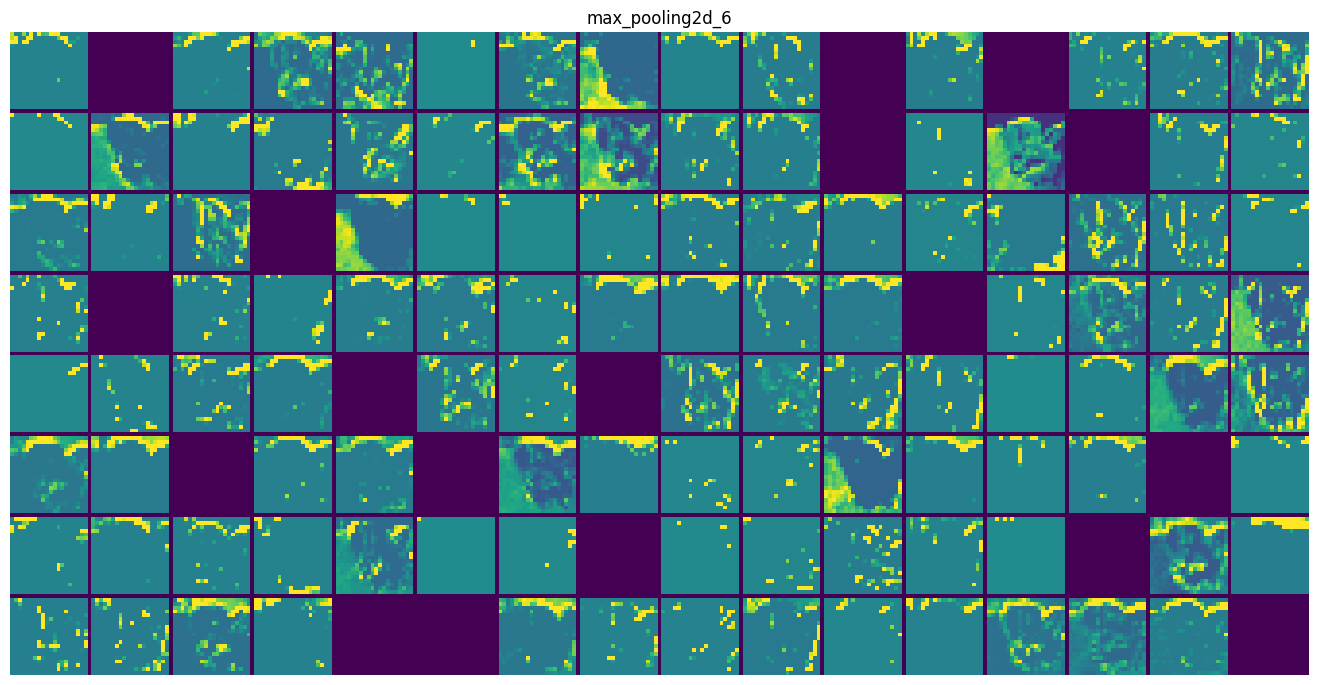

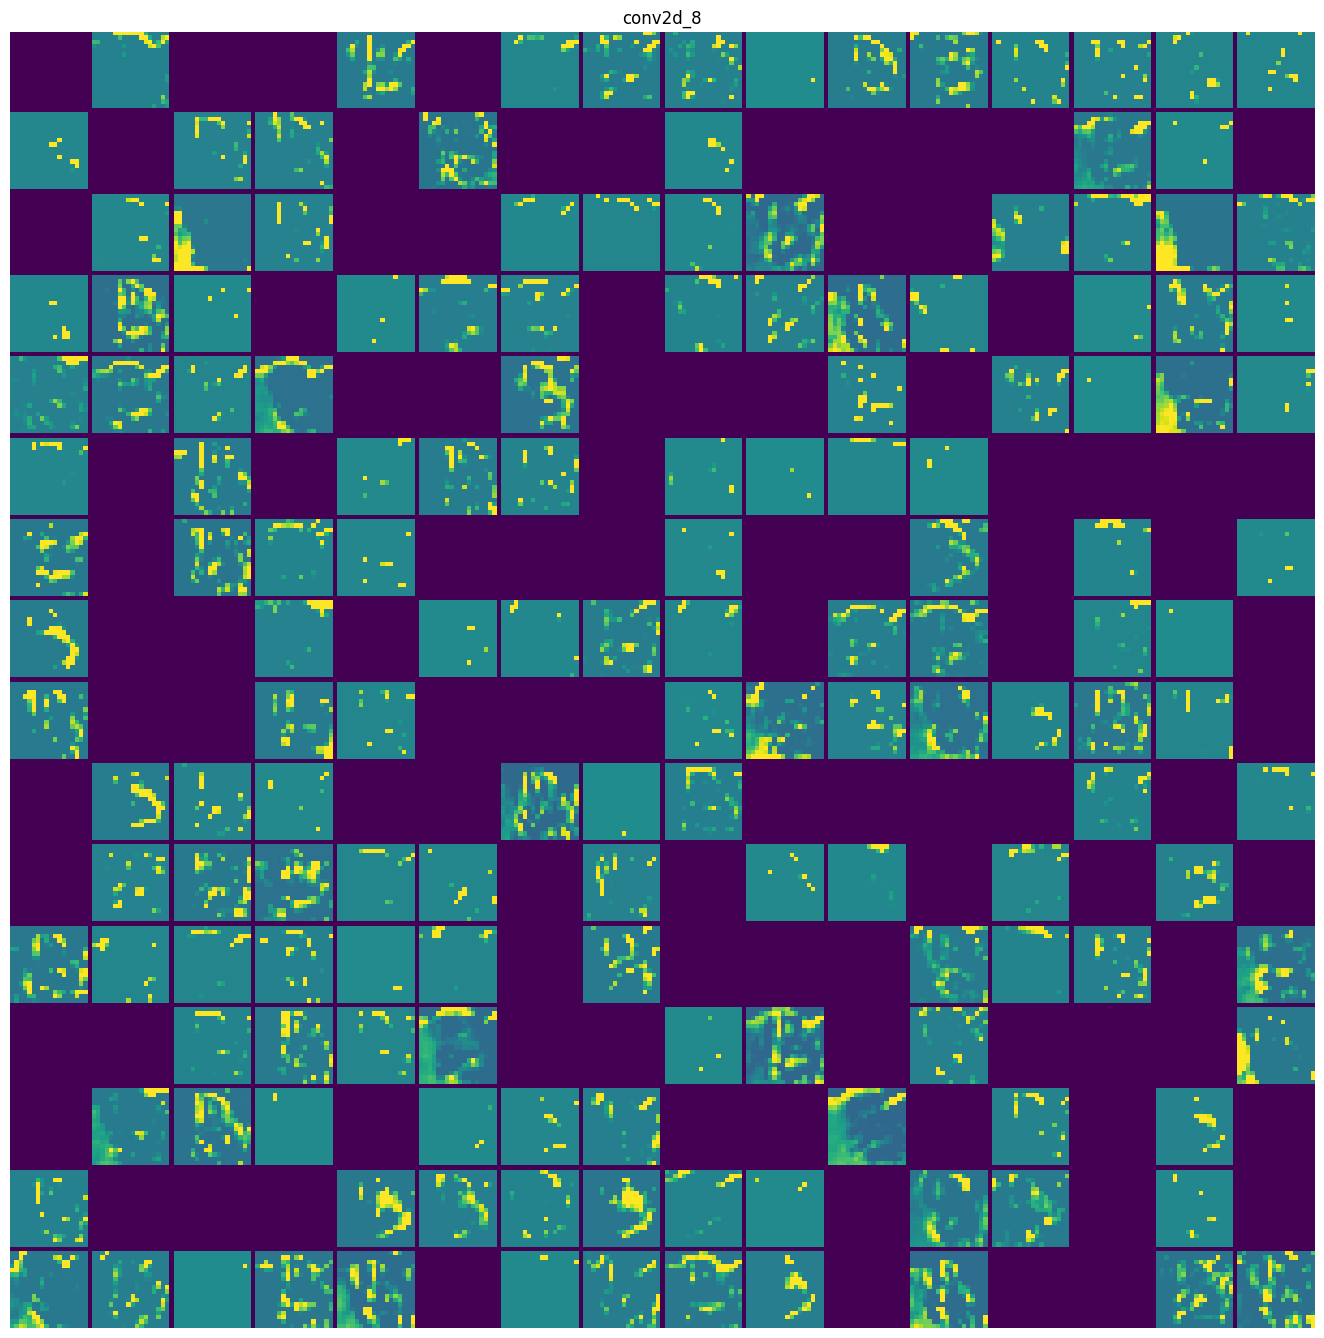

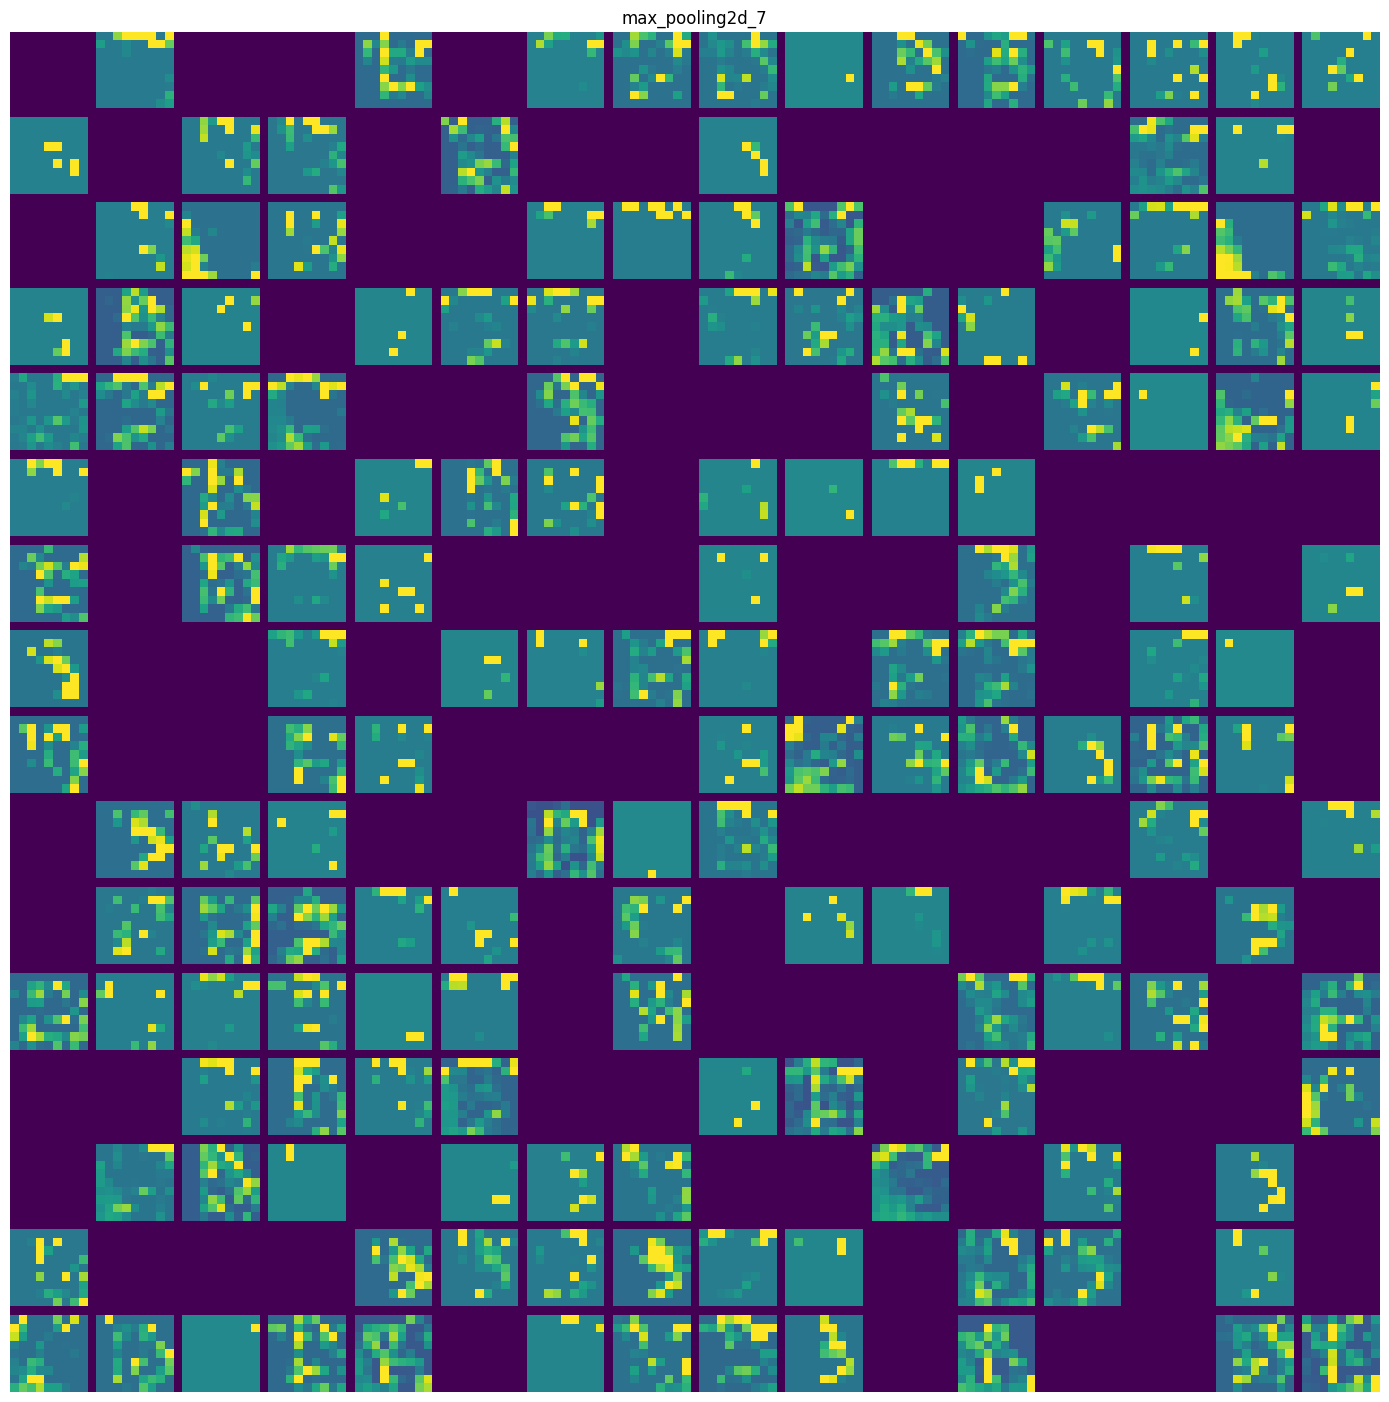

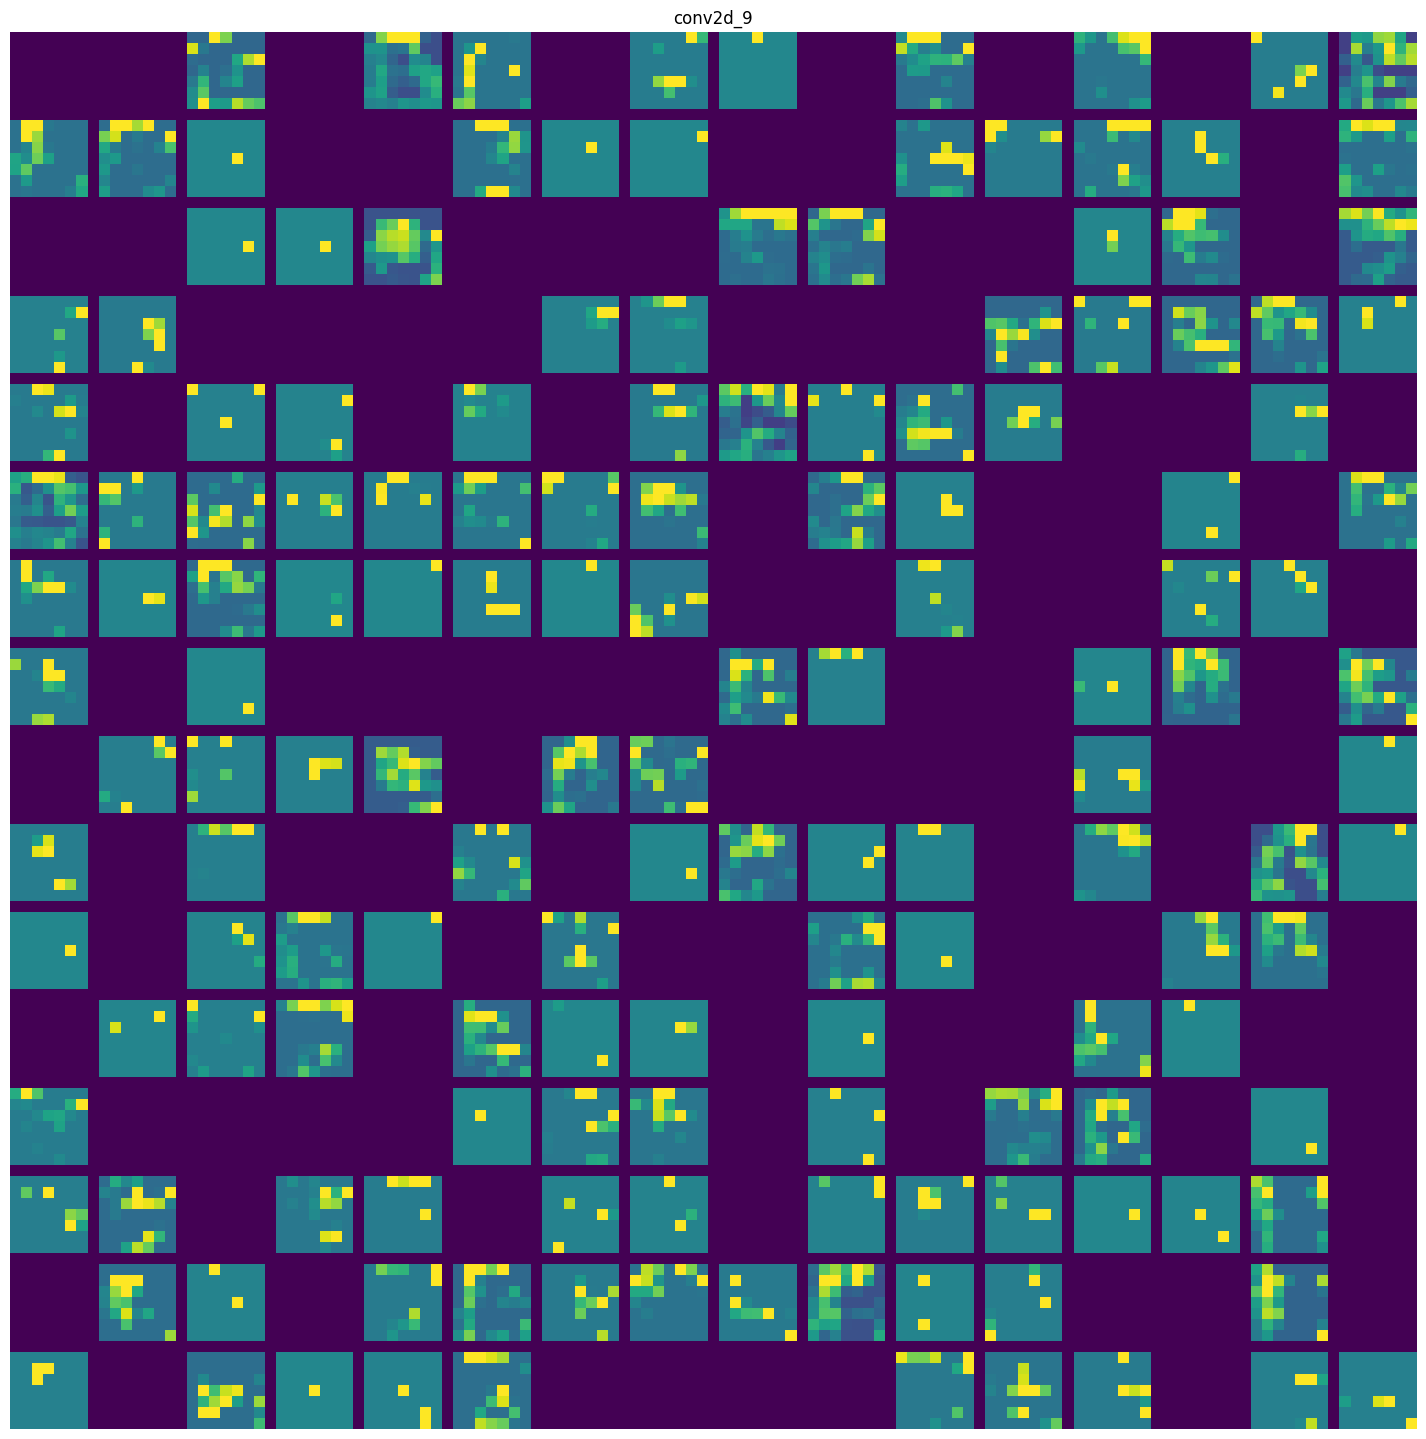

In [21]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    size = layer_activation.shape[1]
    n_features = layer_activation.shape[-1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()

            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128

            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1) : (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row,
            ] = channel_image

    scale = 1.0 / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

## Визуализация фильтров сверточных нейронных сетей

In [22]:
model = keras.applications.xception.Xception(weights="imagenet", include_top=False)

83683744/83683744 [==============================] - 9s 0us/step


In [23]:
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [77]:
layer_name = "block4_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [78]:
activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))

In [79]:
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

### Максимизация потерь методом стохастического градиентного восхождения

In [80]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

In [81]:
img_width = 200
img_height = 200


def generate_filter_pattern(filter_index):
    """
    Функция, которая генерирует изображение, представляющее фильтр
    """
    iterations = 30
    learning_rate = 10.0
    image = tf.random.uniform(
        minval=0.4, maxval=0.6, shape=(1, img_width, img_height, 3)
    )
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

In [82]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

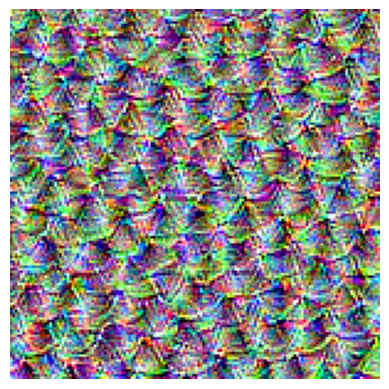

In [83]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
plt.show()

### Создание сетки со всеми шаблонами откликов фильтров в слое

In [84]:
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(generate_filter_pattern(filter_index))
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        row_start = (cropped_width + margin) * i
        row_end = (cropped_width + margin) * i + cropped_width
        column_start = (cropped_height + margin) * j
        column_end = (cropped_height + margin) * j + cropped_height

        stitched_filters[row_start:row_end, column_start:column_end, :] = image

keras.utils.save_img(
    f"stitched_filters/filters_for_layer_{layer_name}.png", stitched_filters
)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

## Визуализация тепловых карт активации класса

In [97]:
model = keras.applications.xception.Xception(weights="imagenet")

In [102]:
img_path = keras.utils.get_file(
    fname="elephant.jpg", origin="https://img-datasets.s3.amazonaws.com/elephant.jpg"
)


def get_img_array(img_path: str, target_size: tuple) -> np.ndarray:
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(img_array)
    return array


img_array = get_img_array(img_path, target_size=(299, 299))

In [103]:
preds = model.predict(img_array)

1/1 [==============================] - 0s 97ms/step


In [104]:
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

[('n02504458', 'African_elephant', 0.86993957), ('n01871265', 'tusker', 0.07695624), ('n02504013', 'Indian_elephant', 0.023541773)]


In [110]:
# Подготовка модели, возвращающей вывод последнего сверточного слоя
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = ["avg_pool", "predictions"]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [123]:
# Повторное применение классификатора к результату последнего сверточного слоя
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [124]:
# Получение градиентов для наиболее вероятного класса

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

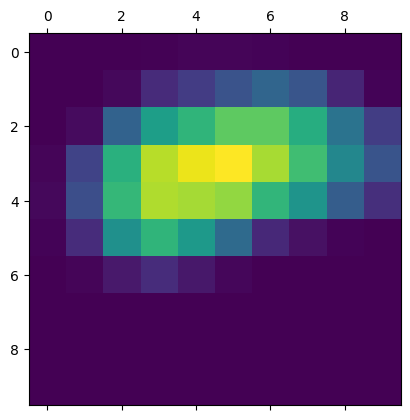

In [125]:
# Объединение и взвешивание по важности тензора градиентов
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [129]:
# Наложение тепловой карты на исходное изображение
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "output/elephant_cam.jpg"
superimposed_img.save(save_path)

/var/folders/pm/cxt85pyn2gvdx0xd2t103j180000gn/T/ipykernel_58695/1123695342.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


<img src='output/elephant_cam.jpg'>